In questo codice si parte da alcuni volumi e da alcuni impianti, dopodichè si ottengono le proiezioni tramite una geometria definita inizialmente. Poichè nella geometria va definita la dim del volume il codice va eseguito separatemente se si considerano volumi di dim diverse cambiando prima la geometria di proiezione (e quindi i parametri H,D,W)
Una volta ottenute le proiezioni si ottengono i dati di input ossia dati di volumi a cui sono stati inseriti diversi impianti.
Sono possibili diverse combinazioni, primo volume con secondo impianto,ecc..
Si ottengono quindi tre dizionari, uno contenente le proiezioni dei volumi iniziali, uno con le proiezioni degli impianti e uno con le proiezioni dei volumi con impianti (tante quante le combinazioni che si vogliono considerare).
Si ottengono a questo punto, per ciascun volume con impianto, 360 immagini formate da : proiezione volume di partenza (iesimo)- proiezione del volume iesimo con inpianto jesimo - proiezione impianto jesimo

In [1]:
#install astra
!wget https://repo.anaconda.com/archive/Anaconda3-2020.02-Linux-x86_64.sh && bash Anaconda3-2020.02-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.insert(0,"/usr/local/lib/python3.7/site-packages/")
!conda install -c astra-toolbox/label/dev astra-toolbox

--2021-10-31 10:27:21--  https://repo.anaconda.com/archive/Anaconda3-2020.02-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 546910666 (522M) [application/x-sh]
Saving to: ‘Anaconda3-2020.02-Linux-x86_64.sh’

Anaconda3-2020.02-L 100%[===================>] 521.57M   177MB/s    in 2.9s    

2021-10-31 10:27:24 (177 MB/s) - ‘Anaconda3-2020.02-Linux-x86_64.sh’ saved [546910666/546910666]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.12=py37_0
    - anaconda-project==0.8.4=py_0
    -

In [5]:
import astra
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
# Utilities for working with remote data
import requests
from io import BytesIO
import zipfile
# Image processing shortcuts
import imageio
import cv2
import copy
from imageio import get_writer
import tensorflow as tf
from IPython import display
from PIL import Image
from google.colab import files
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import save_img

In [22]:
#definisco dim dei volumi considerati (e quindi dei rispettivi impianti)
H=220
W=220
D=208

In [23]:
def project(volume):
# Configuration of projection geometry
  distance_source_origin = 571  # [mm]  
  distance_origin_detector = 408  # [mm] 
  detector_pixel_size = 1.2# [mm]  
  detector_rows =384 # Vertical size of detector [pixels].  
  detector_cols = 384 # Horizontal size of detector [pixels].
  num_of_projections = 360
  angles = np.linspace(-np.pi/2, np.pi/2, num_of_projections)
  vol_geom = astra.creators.create_vol_geom((D,H,W)) 
  #(208,220,220)  #astra chiede:y,x,z , asse di rotazione per astra è lungo asse y e detect e sorg sono in asse x 
  #nel nostro caso l'asse di rotazione è lungo l'asse z che quindi deve essere la prima dimensione quando
  #si da il volume a questa funzione 
  vol_id = astra.data3d.create('-vol', vol_geom, data=volume)

  proj_geom=astra.create_proj_geom('cone', 1.2, 1.2, detector_rows, detector_cols, angles,distance_source_origin ,distance_origin_detector)
  projections_id, projections = astra.creators.create_sino3d_gpu(vol_id, proj_geom, vol_geom)
  return projections
def reconstruct(proj, alg='FDK_CUDA'):
  distance_source_origin = 571  # [mm] 
  distance_origin_detector = 408  # [mm] 
  detector_pixel_size = 1.2  # [mm]  
  detector_rows = 384  # Vertical size of detector [pixels].  
  detector_cols = 384 # Horizontal size of detector [pixels].
  num_of_projections = 360
  angles = np.linspace(-np.pi/2, np.pi/2, num_of_projections)
  proj_geom=astra.create_proj_geom('cone', 1.2, 1.2, detector_rows, detector_cols, angles,distance_source_origin , distance_origin_detector)
  proj_id = astra.data3d.create('-sino', proj_geom, proj)
  rec_vol_geom = astra.creators.create_vol_geom((D,H,W) )
  rec_vol_id = astra.data3d.create('-vol', rec_vol_geom, data=0)
  alg_cfg = astra.astra_dict(alg)
  alg_cfg['ProjectionDataId'] = proj_id
  alg_cfg['ReconstructionDataId'] = rec_vol_id
  alg_id = astra.algorithm.create(alg_cfg)
  astra.algorithm.run(alg_id)
  return astra.data3d.get(rec_vol_id)

In [38]:
#ottieni dizionario con proiezioni true degli m volumi considerati e la ricostruzione ottenuta dalle proiezioni di astra
#proj[0],ad esempio, sara un array di dimensione [384,360,384] in cui si trovano le 360 proiezioni di dim 384*384 ottenute proiettando 
#il primo volume
#in rec_true[0] ci sara un array di dim [G,D,W] contenente la ricostruzione ottenuta dal proj[0]
proj=dict()
rec_true=dict()
m=1  #numero di volumi scaricati, numero di elementi di proj e rec_true
for i in range(m):
  j=i+1
  ctr = requests.get( 
    f'http://144.91.118.156/vol_{j}.zip')
  ctzip = BytesIO(ctr.content)
  ct_fdata= zipfile.ZipFile(ctzip)
  ct_idata = np.array([imageio.imread(ct_fdata.open(fname)) for fname in ct_fdata.namelist()])
  vol=np.transpose(ct_idata,(1,0,2))
  vol = cv2.normalize(vol, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  proj_true=project(vol)
  rec=reconstruct(proj_true)
  cv2.normalize(proj_true, proj_true, 0, 255, cv2.NORM_MINMAX)
  proj[i]=proj_true
  rec_true[i]=rec




In [ ]:
#showing image
img=rec_true[0]
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(img[:,100,:], cmap=plt.cm.gray)


In [39]:
#n=numero di impianti da scaricare, si crea un dizionario masks in cui masks[i] è l' i-esimo impianto scaricato
#j indica il numero con cui è stato salvato l'impianto che si vuole scaricare
#masks[i] ha dim [H,D,W]
masks=dict()
n=2
for i in range(n):
  j=i+1  #in questo caso si scaricano gli impianti 1 e 2
  ctr_m = requests.get( 
    f'http://144.91.118.156/imp_{j}.zip')
  ctzip_m = BytesIO(ctr_m.content)
  ct_fdata_m = zipfile.ZipFile(ctzip_m)
  ct_idata_m = np.array([imageio.imread(ct_fdata_m.open(fname)) for fname in ct_fdata_m.namelist()])
  vol_m=np.transpose(ct_idata_m,(1,0,2))
  vol_m = cv2.normalize(vol_m, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
  masks[i]=vol_m

(220, 208, 220)


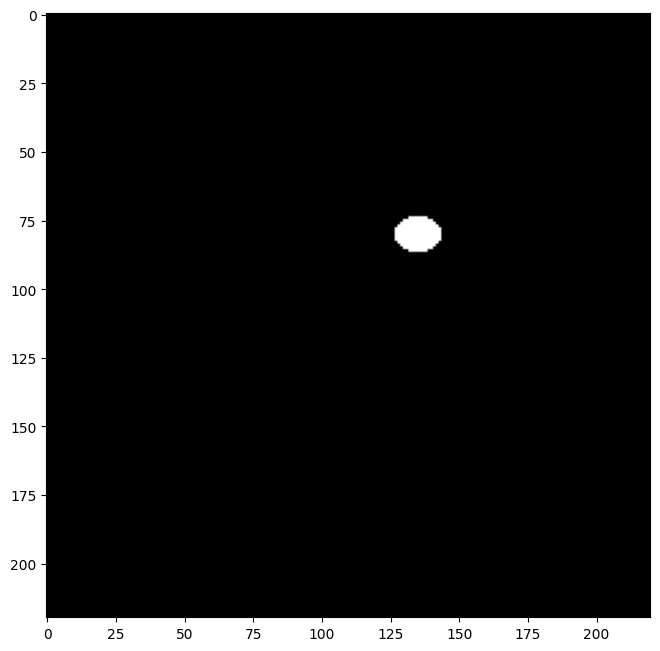

In [31]:
#showing mask image
vol_m=masks[0]
print(vol_m.shape)
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(vol_m[:,27,:], cmap=plt.cm.gray)

In [40]:
#crea proiezioni delle maschere e trasformale in una maschera binaria 0-1, si rende bianco ogni punto in cui la proiezione non è nera
#quindi dove c'è parte della proiezione dell'impianto
#si salvano in un nuovo dizionario mask_projections che avrà lo stesso numero di elementi di masks
#mask_projections[0] ha dim [384,360,384]

mask_projections=dict()
for i in range(n):
  mask=masks[i]
  mask_proj=project(mask)
  mask_proj[mask_proj>0]=255
  mask_projections[i]=mask_proj


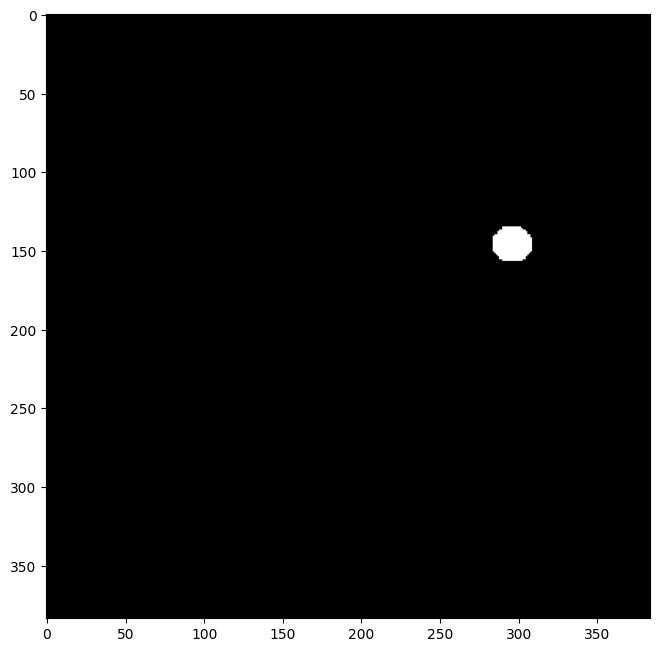

In [33]:
#showing some images
ma=mask_projections[0]
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(ma[:,103,:], cmap=plt.cm.gray)


In [47]:
#creo le proiezioni con la maschera ossia l'input della mia rete. Si ottengono mascherando tramite mask_projection le proiezioni 
#corrette

#definisco una funzione che inserisce nella proiezione i-esima di proj la maschera j esima
def addmask(i,j):  #i indice projtrue , j indice mask
  Pr=copy.copy(proj[i])
  cv2.normalize(Pr, Pr, 0, 255, cv2.NORM_MINMAX)
  mask_proj=mask_projections[j]
  Pr[mask_proj>=Pr]=mask_proj[mask_proj>=Pr]
  return Pr

g=2  #definisco il numero di input che voglio ottenere
#si crea un dizionario con le proiezioni mascherate che avrà g elementi 
mask_vol_projections=dict()
mask_vol_projections[0]=addmask(0,0) #in questo caso creo input del primo volume con impianto 1 e lo considero come input 1
mask_vol_projections[1]=addmask(0,1)  #input 2 che ha sempre il primo volume ma il secondo impianto
#mask_vol_projections[2]=addmask(1,2)
#mask_vol_projections[3]=addmask(1,3)
#mask_vol_projections[4]=addmask(2,4)
#mask_vol_projections[5]=addmask(2,5)


In [48]:
#salvo le immagini nei tre dizionari

#MASK_PROJECTIONS ha n elementi che rappresentano i vari impianti
for i in range(n):   
  s=i+1 #indica l'indice dell'impianto
  projections=mask_projections[i]
  cv2.normalize(projections, projections, 0, 255, cv2.NORM_MINMAX)
  projections = projections.astype(np.uint8)
  k=projections.shape[1]
  for j in range(k):
   projection = projections[:, j,:]
   l=j+100
   img = Image.fromarray(projection,'L')
   img.save(f'mask_{s}_proj_{l}.png' )

#MASK__VOL_PROJECTIONS ha n elementi che rappresentano gli input: maschera dell'impiantosu proiezione del volume 
for i in range(g):
  s=i+1   #indice dell'input
  projections=mask_vol_projections[i]
  cv2.normalize(projections, projections, 0, 255, cv2.NORM_MINMAX)
  projections = projections.astype(np.uint8)
  k=projections.shape[1]
  for j in range(k):
   projection = projections[:, j,:]
   l=j+100
   img = Image.fromarray(projection,'L')
   img.save(f'mask_vol_{s}_proj_{l}.png' )

#PROJ: salvo le proiezioni senza impianti, in questo caso sono m=numero volumi considerati
for i in range(m):  
  s=i+1
  projectionsA=proj[i]
  cv2.normalize(projectionsA, projectionsA, 0, 255, cv2.NORM_MINMAX)
  projectionsA = projectionsA.astype(np.uint8)
  k=projectionsA.shape[1]
  for j in range(k):
    projection = projectionsA[:, j,:]
    l=j+100
    img = Image.fromarray(projection,'L')
    img.save(f'true_{s}_proj_{l}.png' )

In [44]:
#per ogni dato di input (mask_vol projections) ottengo un'immagine con vicine le corrispondenti proj_true, mask_vol_proj e mask_proj
#bisogna definire
#a=input considerato
#b=indice della maschera che è stata messa nell'input
#c=volume dell'input
#ad esempio in questo caso posso considerare il 2 input che ha il 2 impianto e il primo volume
a=2
b=2
c=1
for j in range(k):
  l=j+100
  images = [Image.open(x) for x in [f'true_{c}_proj_{l}.png', f'mask_vol_{b}_proj_{l}.png', f'mask_{a}_proj_{l}.png']]
  widths, heights = zip(*(t.size for t in images))
  total_width = sum(widths)
  max_height = max(heights)
  new_im = Image.new('L', (total_width, max_height))
  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

    new_im.save(f'datopr_{l}.png')
!zip -r datoreteproj_1.zip . -i 'datopr_*.png'
files.download( 'datoreteproj_1.zip' )
#!rm 'proj.zip'


  adding: datopr_347.png (deflated 2%)
  adding: datopr_328.png (deflated 2%)
  adding: datopr_101.png (deflated 3%)
  adding: datopr_165.png (deflated 2%)
  adding: datopr_288.png (deflated 2%)
  adding: datopr_306.png (deflated 2%)
  adding: datopr_334.png (deflated 2%)
  adding: datopr_268.png (deflated 2%)
  adding: datopr_224.png (deflated 2%)
  adding: datopr_293.png (deflated 2%)
  adding: datopr_200.png (deflated 2%)
  adding: datopr_358.png (deflated 2%)
  adding: datopr_212.png (deflated 2%)
  adding: datopr_144.png (deflated 3%)
  adding: datopr_336.png (deflated 2%)
  adding: datopr_150.png (deflated 2%)
  adding: datopr_104.png (deflated 3%)
  adding: datopr_448.png (deflated 3%)
  adding: datopr_278.png (deflated 2%)
  adding: datopr_363.png (deflated 2%)
  adding: datopr_175.png (deflated 2%)
  adding: datopr_396.png (deflated 3%)
  adding: datopr_203.png (deflated 2%)
  adding: datopr_176.png (deflated 2%)
  adding: datopr_261.png (deflated 2%)
  adding: datopr_160.png 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#for i in range(360):
  #j=i+100
 # %rm 'datopr_{j}.png'